# House Prices: Advanced Regression Techniques

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home

Source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [331]:
#Import required libraries
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
from math import sqrt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [332]:
#Source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
train = pd.read_csv("datasets/housing/train.csv")
test = pd.read_csv("datasets/housing/test.csv")
y_train_data = train["SalePrice"]
print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (1460, 81)
Test:  (1459, 80)


In [333]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [334]:
#I'm going to combine test and train data briefly while I do data cleaning and feature engineering, then I'll split it back apart
data = pd.concat([train, test], sort=False)
data = data.reset_index(drop=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [335]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [336]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

Great news! No missing data.

In [337]:
# Feature engineering
data['YrBltAndRemod']=data['YearBuilt']+data['YearRemodAdd']
data['TotalSF']=data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] +
                                 data['1stFlrSF'] + data['2ndFlrSF'])

data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) +
                               data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                              data['EnclosedPorch'] + data['ScreenPorch'] +
                              data['WoodDeckSF'])

# Add to num variables: 'YrBltAndRemod', 'TotalSF', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf'

data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Add to cat variables: 'haspool', 'has2ndfloor', 'hasgarage', 'hasbsmt', 'hasfireplace'

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

# shape        
print('Shape data: {}'.format(data.shape))

#LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses 
#in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

Shape data: (2919, 91)


In [338]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 91 columns):
Id                   2919 non-null int64
MSSubClass           2919 non-null int64
MSZoning             2915 non-null object
LotFrontage          2919 non-null float64
LotArea              2919 non-null int64
Street               2919 non-null int64
Alley                2919 non-null int64
LotShape             2919 non-null int64
LandContour          2919 non-null object
Utilities            2917 non-null object
LotConfig            2919 non-null object
LandSlope            2919 non-null int64
Neighborhood         2919 non-null object
Condition1           2919 non-null object
Condition2           2919 non-null object
BldgType             2919 non-null object
HouseStyle           2919 non-null object
OverallQual          2919 non-null int64
OverallCond          2919 non-null int64
YearBuilt            2919 non-null int64
YearRemodAdd         2919 non-null int64
RoofStyle            

# Explore the data

In [339]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,...,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2918.000000,2918.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,4.266530,69.542994,10168.114080,0.995889,1.891059,1.947585,0.053786,6.089072,4.564577,...,3955.577252,2548.048663,1987.276559,2.218375,182.959575,0.004454,0.428571,0.945872,0.972936,0.513532
std,842.787043,4.344907,21.703256,7886.996359,0.063996,0.423503,1.409721,0.248750,1.409947,1.113131,...,46.142560,804.677866,760.779147,0.808455,160.021404,0.066598,0.494956,0.226309,0.162298,0.499902
min,1.000000,0.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,3830.000000,334.000000,334.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,730.500000,0.000000,60.000000,7478.000000,1.000000,2.000000,0.000000,0.000000,5.000000,4.000000,...,3920.000000,2000.500000,1488.000000,1.500000,48.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1460.000000,4.000000,70.000000,9453.000000,1.000000,2.000000,3.000000,0.000000,6.000000,4.000000,...,3954.000000,2450.000000,1848.000000,2.000000,164.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,2189.500000,6.000000,80.000000,11570.000000,1.000000,2.000000,3.000000,0.000000,7.000000,5.000000,...,4002.000000,2991.750000,2377.000000,2.500000,266.500000,0.000000,1.000000,1.000000,1.000000,1.000000
max,2919.000000,15.000000,313.000000,215245.000000,1.000000,2.000000,3.000000,2.000000,10.000000,8.000000,...,4020.000000,11752.000000,11286.000000,7.000000,1424.000000,1.000000,1.000000,1.000000,1.000000,1.000000


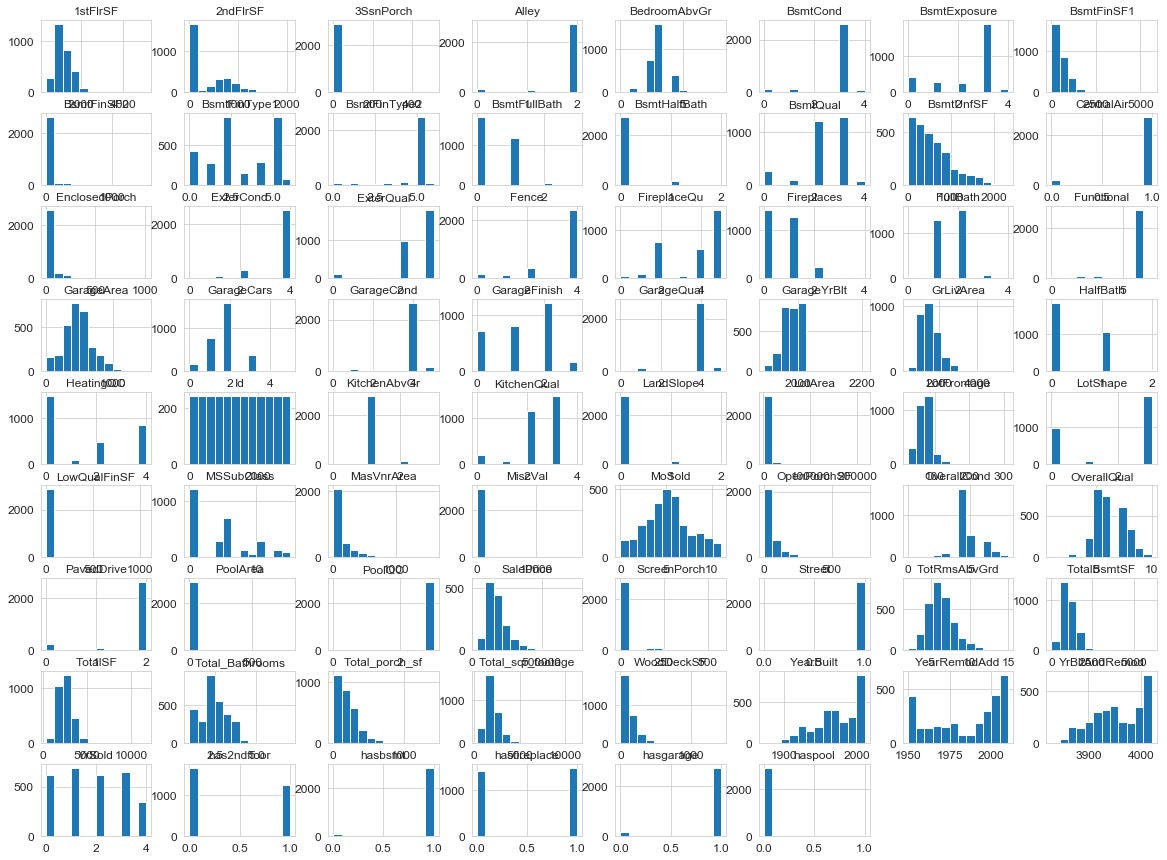

In [340]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=12, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

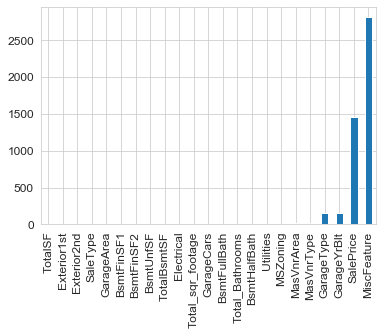

In [341]:
import seaborn as sns
sns.set_style("whitegrid")
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

No remaining material misssing features to dataset. We expect SalePrice to be missing on test set, sot his is ok. 

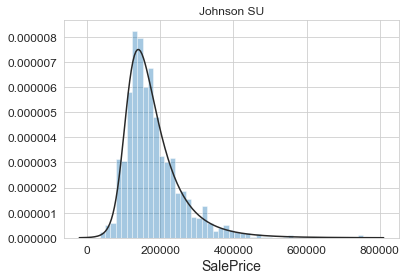

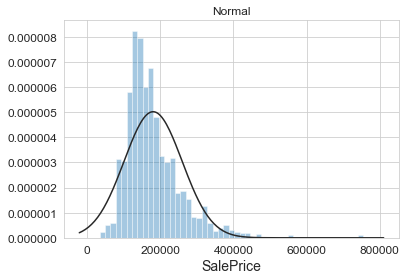

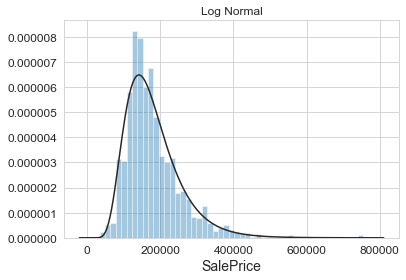

In [342]:
import scipy.stats as stats
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

Looks like distribution is the right side of the normal distribution.

In [343]:
corr_matrix = data.corr()

In [344]:
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice            1.000000
OverallQual          0.790982
TotalSF              0.782260
GrLivArea            0.708624
Total_sqr_footage    0.708047
                       ...   
FireplaceQu         -0.459605
GarageFinish        -0.549247
KitchenQual         -0.589189
BsmtQual            -0.620886
ExterQual           -0.636884
Name: SalePrice, Length: 70, dtype: float64

In [345]:
#Drop columns if needed
data.drop("Id", axis=1)
data.drop("SalePrice", axis=1, inplace=True)

In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 90 columns):
Id                   2919 non-null int64
MSSubClass           2919 non-null int64
MSZoning             2915 non-null object
LotFrontage          2919 non-null float64
LotArea              2919 non-null int64
Street               2919 non-null int64
Alley                2919 non-null int64
LotShape             2919 non-null int64
LandContour          2919 non-null object
Utilities            2917 non-null object
LotConfig            2919 non-null object
LandSlope            2919 non-null int64
Neighborhood         2919 non-null object
Condition1           2919 non-null object
Condition2           2919 non-null object
BldgType             2919 non-null object
HouseStyle           2919 non-null object
OverallQual          2919 non-null int64
OverallCond          2919 non-null int64
YearBuilt            2919 non-null int64
YearRemodAdd         2919 non-null int64
RoofStyle            

# Prepare the data

In [347]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

## Numeric columns

In [404]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
num_columns = ['OverallQual', 'OverallCond', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'YrBltAndRemod', 'TotalSF', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf']

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(num_columns)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [405]:
num_pipeline.fit_transform(data)

array([[7.000e+00, 4.000e+00, 6.500e+01, ..., 2.416e+03, 3.500e+00,
        6.100e+01],
       [6.000e+00, 7.000e+00, 8.000e+01, ..., 2.240e+03, 2.500e+00,
        2.980e+02],
       [7.000e+00, 4.000e+00, 6.800e+01, ..., 2.272e+03, 3.500e+00,
        4.200e+01],
       ...,
       [5.000e+00, 6.000e+00, 1.600e+02, ..., 2.448e+03, 2.000e+00,
        4.740e+02],
       [5.000e+00, 4.000e+00, 6.200e+01, ..., 1.307e+03, 1.500e+00,
        1.120e+02],
       [7.000e+00, 4.000e+00, 7.400e+01, ..., 2.758e+03, 2.500e+00,
        2.380e+02]])

In [406]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

## Categorical columns

In [407]:
from sklearn.preprocessing import OneHotEncoder

In [408]:
cat_columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'haspool', 'has2ndfloor', 'hasgarage', 'hasbsmt', 'hasfireplace']

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_columns)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [409]:
cat_pipeline.fit_transform(data)

array([[0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [410]:
#Code to get categorical column names automatically
cat_data = data[cat_columns]
cat_data = pd.DataFrame(cat_data)
cat_data = cat_data.applymap(str)

#Imput the NaN values to most frequent value to avoid OneHotEncoder errors
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values='NaN', strategy='most_frequent', copy=False)
imp.fit(cat_data) 

#Create dummy encoder just to extract feature names
encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(cat_data)
cat_cols = encoder.get_feature_names(cat_columns)
cat_cols = cat_cols.tolist()

In [411]:
#Combine numerical column names with categorical column names
col_names = num_columns + cat_cols
len(col_names)

341

In [412]:
#Need to remove all the columns with NaN
col_names = [ x for x in col_names if "_nan" not in x ]
len(col_names)

332

In [413]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [414]:
X_data = preprocess_pipeline.fit_transform(data)
X_data.shape

(2919, 332)

In [415]:
X_train, X_test = X_data[:len(train)], X_data[len(train):]

In [416]:
# Test split
print("train_data: ", X_train.shape)
print("Train: ", train.shape)
print("test_data: ", X_test.shape)
print("Test: ", test.shape)

train_data:  (1460, 332)
Train:  (1460, 81)
test_data:  (1459, 332)
Test:  (1459, 80)


In [417]:
y_train_data.shape

(1460,)

In [418]:
#Train / Vaidation Split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_data, test_size=0.2, random_state=42)
# Test split
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)

X_train:  (1168, 332)
X_val:  (292, 332)
y_train:  (1168,)
y_val:  (292,)


# Shortlist promising models

In [419]:
#Function to automate calculating metrics
def rmse_score(y_train, pred):
    rmsle = sqrt(sklearn.metrics.mean_squared_error(np.log(y_train), np.log(pred)))
    rmse = sqrt(sklearn.metrics.mean_squared_error(y_train, pred))
    print("RMSE", rmse)
    print("RMSLE", rmsle)

## Linear Regression

In [420]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [421]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [422]:
lin_pred_train = lin_reg.predict(X_train)
lin_pred = lin_reg.predict(X_val)
lin_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, lin_pred))
#lin_rmse = rmse_score(y_val, lin_pred)
print("lin_pred", lin_rmse)

lin_pred 69596.25944118743


In [423]:
coeff_df = pd.DataFrame(lin_reg.coef_, col_names)
coeff_df.sort_values(by = 0, ascending = False)

,0
haspool_0,1.302864e+06
PoolQC_3,1.302864e+06
RoofMatl_ClyTile,9.250756e+05
MiscFeature_TenC,6.252111e+05
PoolQC_0,3.306480e+05
...,...
MiscFeature_Shed,-2.060060e+05
MiscFeature_Gar2,-2.157477e+05
PoolQC_1,-5.246519e+05
PoolQC_2,-1.108860e+06


## Tree Regression

In [424]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42,max_depth = 100)

In [425]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [426]:
tree_pred_train = tree_reg.predict(X_train)
tree_pred = tree_reg.predict(X_val)
rmse_score(y_val, tree_pred)
tree_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, tree_pred))

RMSE 41377.95248332533
RMSLE 0.2068841654886991


### Tree intepretation

[Text(620.0, 652.3199999999999, 'OverallQual <= 8.0\nmse = 5964550380.0\nsamples = 1168\nvalue = 181442.0'),
 Text(310.0, 507.36, 'TotalSF <= 2289.0\nmse = 2363399388.0\nsamples = 984\nvalue = 158879.0'),
 Text(155.0, 362.4, 'YrBltAndRemod <= 3947.0\nmse = 834788764.0\nsamples = 457\nvalue = 126377.0'),
 Text(77.5, 217.44000000000005, 'TotalSF <= 1669.0\nmse = 666299696.0\nsamples = 290\nvalue = 114560.0'),
 Text(38.75, 72.48000000000002, '\n  (...)  \n'),
 Text(116.25, 72.48000000000002, '\n  (...)  \n'),
 Text(232.5, 217.44000000000005, 'Total_Bathrooms <= 2.0\nmse = 463820805.0\nsamples = 167\nvalue = 146897.0'),
 Text(193.75, 72.48000000000002, '\n  (...)  \n'),
 Text(271.25, 72.48000000000002, '\n  (...)  \n'),
 Text(465.0, 362.4, 'OverallQual <= 6.0\nmse = 1978479337.0\nsamples = 527\nvalue = 187064.0'),
 Text(387.5, 217.44000000000005, 'Total_sqr_footage <= 2462.0\nmse = 1243438601.0\nsamples = 304\nvalue = 168289.0'),
 Text(348.75, 72.48000000000002, '\n  (...)  \n'),
 Text(426

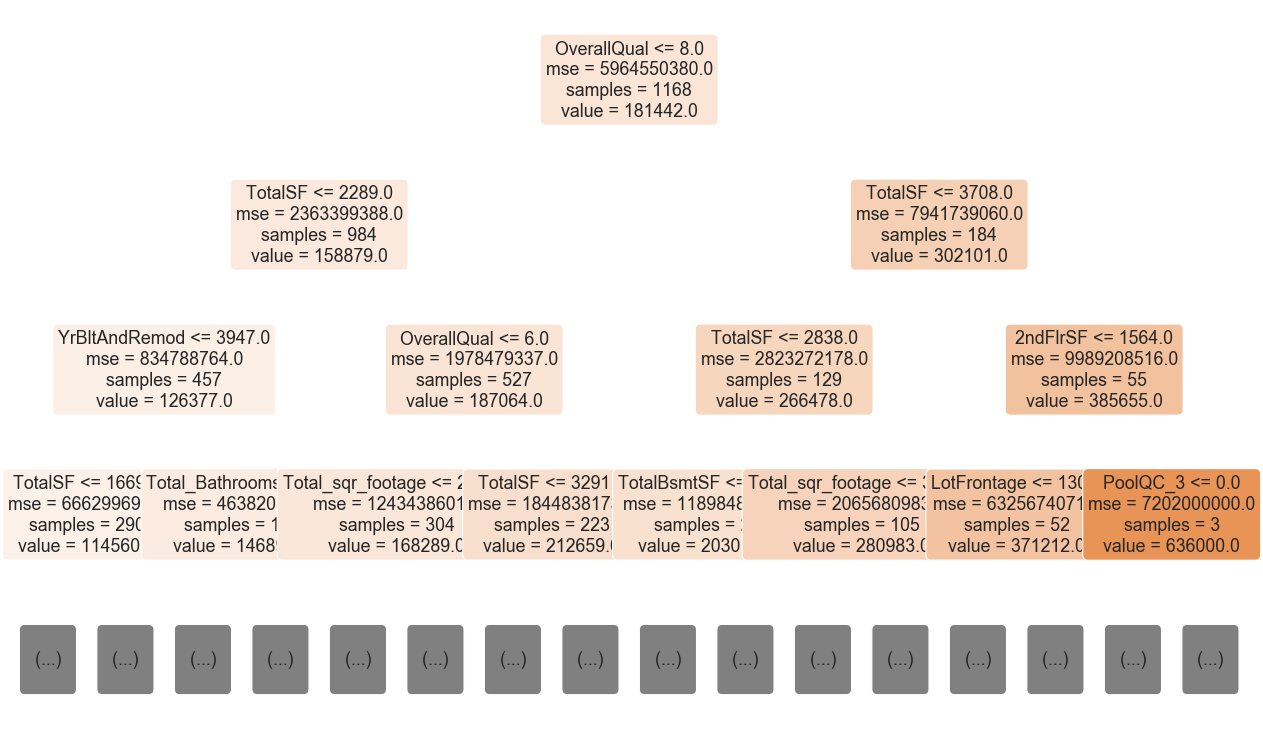

In [427]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
sklearn.tree.plot_tree(tree_reg, max_depth=3, feature_names=col_names, class_names=None, label='all', filled=True, impurity=True, node_ids=False, proportion=False, rotate=False, rounded=True, precision=0, ax=None, fontsize=16)

## Random forest

In [437]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rnd_reg = RandomForestRegressor(n_estimators=100, max_leaf_nodes=3000, n_jobs=-1)

In [438]:
rnd_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=3000,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [430]:
rnd_pred_train = rnd_reg.predict(X_train)
rnd_pred = rnd_reg.predict(X_val)
rmse_score(y_val, rnd_pred)
rnd_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, rnd_pred))

RMSE 29425.049496729804
RMSLE 0.1495293568997878


In [444]:
feature_importances = rnd_reg.feature_importances_
attributes = num_columns + cat_columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3909892045722331, 'TotalSF'),
 (0.3396946145727228, 'OverallQual'),
 (0.04090821978384427, 'Total_sqr_footage'),
 (0.027396543529574838, 'YrBltAndRemod'),
 (0.022540570464461902, '2ndFlrSF'),
 (0.012354766398387059, 'YearBuilt'),
 (0.012009564508606806, 'GrLivArea'),
 (0.00993741525000904, 'LotFrontage'),
 (0.008540341149419012, 'LotArea'),
 (0.008200165665000213, 'YearRemodAdd'),
 (0.007757371290054878, 'GarageArea'),
 (0.007224528008601632, 'GarageCars'),
 (0.006990974352216842, 'Total_Bathrooms'),
 (0.005012651731839241, 'BsmtFinSF1'),
 (0.004571629725414121, 'OverallCond'),
 (0.003961578176542528, 'TotalBsmtSF'),
 (0.003617418994846333, 'BsmtUnfSF'),
 (0.0035729057292837765, 'Total_porch_sf'),
 (0.003480180594237725, 'OpenPorchSF'),
 (0.003142624122047284, 'GarageYrBlt'),
 (0.00299333341917988, '1stFlrSF'),
 (0.0028705956679906984, 'ScreenPorch'),
 (0.002834855461043175, 'KitchenAbvGr'),
 (0.0026416993233882424, 'WoodDeckSF'),
 (0.0021912418428614196, 'MoSold'),
 (0.00209171943

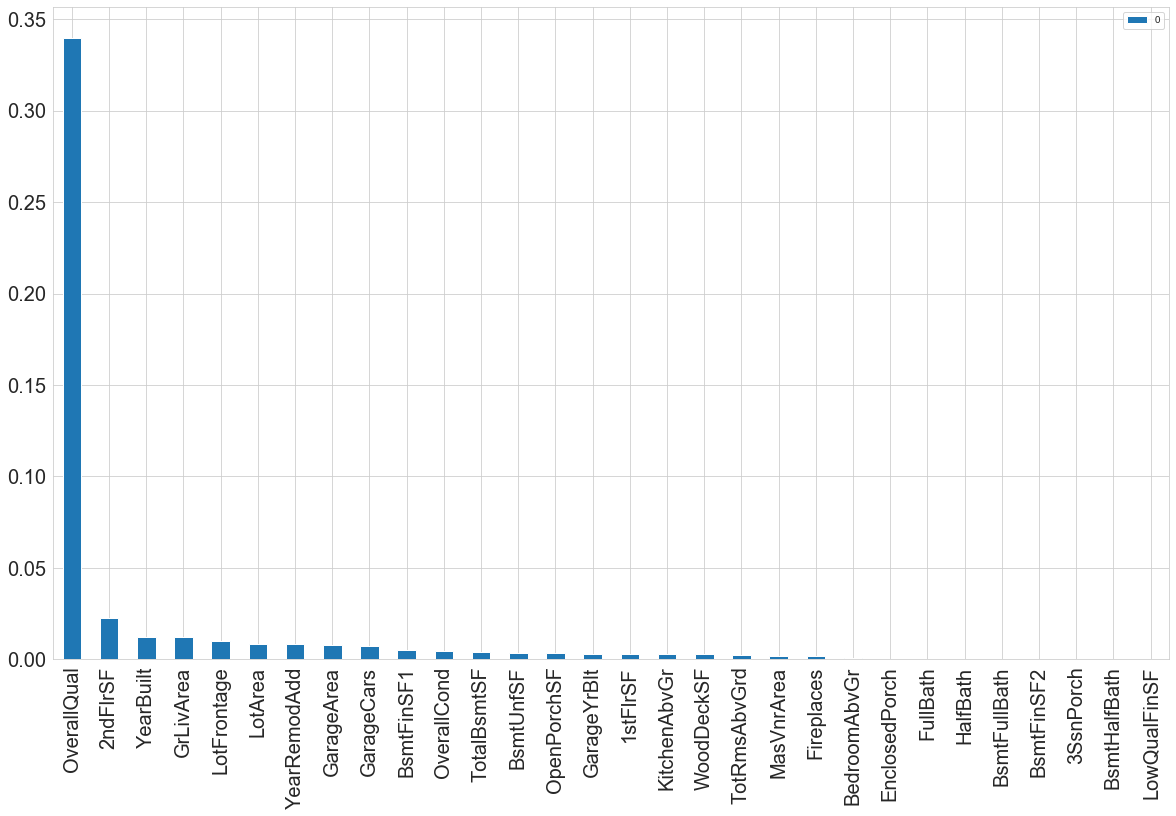

In [445]:
feature_df = pd.DataFrame(feature_importances, col_names)
feature_df = feature_df[0:30]
feature_df = feature_df.sort_values(0,ascending=False)
import seaborn as sns
sns.set_style("whitegrid")
feature_df.plot.bar(figsize=(20, 12), fontsize=20)

## XGBoost

In [446]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [447]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)

In [451]:
xgb_pred_train = xgb_reg.predict(X_train)
xgb_pred = xgb_reg.predict(X_val)
#rmse_score(y_val, xgb_pred)
xgb_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, xgb_pred))
print("xgb_pred", xgb_rmse)

xgb_pred 30443.260632815476


In [452]:
np.savetxt("bike_pred.csv", xgb_pred, delimiter=",")
#Score 1.37398
#Target 0.41 to be top 10%

## Ensemble

In [453]:
from sklearn.ensemble import VotingRegressor

In [454]:
estimators = [('gb', xgb_reg), ('rf', rnd_reg)] #('lr', lin_reg)

In [455]:
voting_reg = VotingRegressor(estimators)

In [456]:
voting_reg.fit(X_train, y_train, None)

VotingRegressor(estimators=[('gb',
                             XGBRegressor(base_score=0.5, booster=None,
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=0,
                                          num_paral...
                                          verbosity=None)),
                            ('rf',
                             RandomForestR

In [457]:
voting_reg.voting = "hard"
voting_pred_train = voting_reg.predict(X_train)
voting_pred = voting_reg.predict(X_val)

In [458]:
rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, voting_pred))
print("voting rmse", rmse)

voting rmse 29026.385886106124


In [459]:
voting_reg.voting = "soft"
voting_pred = voting_reg.predict(X_val)
voting_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, voting_pred))
print("voting rmse", voting_rmse)

voting rmse 29026.385886106124


## Stacking Ensemble

In [460]:
predictions = np.empty((len(X_train), 5))

predictions[:,0] = tree_pred_train
predictions[:,1] = lin_pred_train
predictions[:,2] = rnd_pred_train
predictions[:,3] = xgb_pred_train
predictions[:,4] = voting_pred_train

In [461]:
predictions_val = np.empty((len(X_val), 5))

predictions_val[:,0] = tree_pred
predictions_val[:,1] = lin_pred
predictions_val[:,2] = rnd_pred
predictions_val[:,3] = xgb_pred
predictions_val[:,4] = voting_pred

In [462]:
rnd_forest_blender = RandomForestRegressor(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(predictions, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [463]:
stack_pred = rnd_forest_blender.predict(predictions_val)

In [464]:
rmse_score(y_val, stack_pred)
stack_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, stack_pred))

RMSE 35355.39065413797
RMSLE 0.18637636897520707


# Preliminary Results from models

In [465]:
print("tree score", tree_rmse)
print("lin score", lin_rmse)
print("random forest score", rnd_rmse)
print("XGBoost score", xgb_rmse)
print("Voting score", voting_rmse)
print("Stacking score", stack_rmse)

tree score 41377.95248332533
lin score 69596.25944118743
random forest score 29617.75753860908
XGBoost score 30443.260632815476
Voting score 29026.385886106124
Stacking score 35355.39065413797


It looks like Randomforest, XGBoost, and Voting scored the best. I am going to focus my efforts on Random Forest because it is a robust technique that makes it hard to overfit.

# Fine-tune the system

To fine tune model, let's do a random grid search by tweaking the parameters of the random forest. 

In [174]:
max_features = len(pd.DataFrame(X_train).columns)
print(max_features)

318


In [183]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=100, high=200),
        'max_features': randint(low=1, high=250),
        'max_leaf_nodes': randint(low=1000, high=2000),
        'max_depth': randint(low=15, high=75),
        'min_samples_leaf': randint(low=1, high=4)
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_log_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [184]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.1434282910666792 {'max_depth': 53, 'max_features': 180, 'max_leaf_nodes': 1860, 'min_samples_leaf': 3, 'n_estimators': 171}
0.1423274031802228 {'max_depth': 35, 'max_features': 103, 'max_leaf_nodes': 1121, 'min_samples_leaf': 3, 'n_estimators': 186}
0.14241094554096534 {'max_depth': 25, 'max_features': 203, 'max_leaf_nodes': 1087, 'min_samples_leaf': 1, 'n_estimators': 199}
0.14141748646593916 {'max_depth': 54, 'max_features': 152, 'max_leaf_nodes': 1130, 'min_samples_leaf': 2, 'n_estimators': 152}
0.14208149372291554 {'max_depth': 16, 'max_features': 88, 'max_leaf_nodes': 1491, 'min_samples_leaf': 2, 'n_estimators': 137}
0.1426864260216739 {'max_depth': 16, 'max_features': 192, 'max_leaf_nodes': 1955, 'min_samples_leaf': 1, 'n_estimators': 132}
0.1421143113835987 {'max_depth': 26, 'max_features': 58, 'max_leaf_nodes': 1021, 'min_samples_leaf': 1, 'n_estimators': 188}
0.14401083727092526 {'max_depth': 63, 'max_features': 219, 'max_leaf_nodes': 1058, 'min_samples_leaf': 3, 'n_estimato

# Best models are: 
Round 1
0.15593371928993635 {'max_depth': 99, 'max_features': 198, 'max_leaf_nodes': 1931, 'min_samples_leaf': 16, 'n_estimators': 97}
0.15050292982098412 {'max_depth': 90, 'max_features': 9, 'max_leaf_nodes': 1368, 'min_samples_leaf': 1, 'n_estimators': 136}
0.14888798618820048 {'max_depth': 37, 'max_features': 50, 'max_leaf_nodes': 1022, 'min_samples_leaf': 6, 'n_estimators': 54}
0.15045459440407288 {'max_depth': 15, 'max_features': 242, 'max_leaf_nodes': 2042, 'min_samples_leaf': 9, 'n_estimators': 90}
0.15908152166908207 {'max_depth': 39, 'max_features': 192, 'max_leaf_nodes': 956, 'min_samples_leaf': 21, 'n_estimators': 161}

Let's take the median value of these top models
max_depth: 15-100
max_features: 9-250
max_leaf nodes: 1000-2000
min_samples_leaf: 1-20
n_estimators: 50-200

Round 2
0.14180724955184207 {'max_depth': 38, 'max_features': 69, 'max_leaf_nodes': 1883, 'min_samples_leaf': 2, 'n_estimators': 188}
0.14241288328145416 {'max_depth': 38, 'max_features': 131, 'max_leaf_nodes': 1661, 'min_samples_leaf': 2, 'n_estimators': 137}
0.1432730552107784 {'max_depth': 44, 'max_features': 38, 'max_leaf_nodes': 1385, 'min_samples_leaf': 1, 'n_estimators': 107}
0.14377148183950791 {'max_depth': 17, 'max_features': 148, 'max_leaf_nodes': 1763, 'min_samples_leaf': 4, 'n_estimators': 196}
0.14247201153264694 {'max_depth': 73, 'max_features': 243, 'max_leaf_nodes': 1085, 'min_samples_leaf': 2, 'n_estimators': 94}

Let's take the median value of these top models
max_depth: 17-73
max_features: 38-250
max_leaf nodes: 1000-2000
min_samples_leaf: 1-4
n_estimators: 100-200

Round 3
0.14134601249928133 {'max_depth': 41, 'max_features': 137, 'max_leaf_nodes': 1317, 'min_samples_leaf': 1, 'n_estimators': 196}



In [185]:
final_rf_model = RandomForestRegressor(n_estimators=200, max_leaf_nodes=1317, max_features = 137, min_samples_leaf = 1, max_depth = 41, n_jobs=-1)

In [192]:
estimators = [('gb', xgb_reg), ('rf', final_rf_model)] #('lr', lin_reg)

In [193]:
voting_reg = VotingRegressor(estimators)

In [194]:
voting_reg.fit(X_train, y_train, None)

VotingRegressor(estimators=[('gb',
                             XGBRegressor(base_score=0.5, booster=None,
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=0,
                                          num_paral...
                                          verbosity=None)),
                            ('rf',
                             RandomForestR

In [205]:
voting_reg.voting = "soft"
voting_pred_train = voting_reg.predict(X_train)
voting_pred = voting_reg.predict(X_val)

In [206]:
rmse_score(y_val, voting_pred)

RMSE 28464.280494994622
RMSLE 0.14685557457957557


In [ ]:
np.savetxt("house_y_pred.csv", final_pred, delimiter=",")
np.savetxt("house_y_val.csv", y_val, delimiter=",")

# Making predictions on test set

In [199]:
final_pred = final_model.predict(X_test)

In [200]:
final_pred.shape

(1459,)

In [201]:
np.savetxt("house_pred.csv", final_pred, delimiter=",")

My final score was 0.14612 compared to the 10th percentile score of 0.11676. So not too far off from an excellent model. Not to mention this competition has been super picked over. 